In [2]:
import qtensor
import numpy as np
import torch

from circuit_11 import circuit_11, get_circ_and_peo

In [3]:
%load_ext autoreload
%autoreload 2

In [383]:
N = 8
FIXED = 4
LAYERS = 3

## Read eignestates

In [384]:
from pathlib import Path
def read_eigenstate(L=8, delta=0):
    data_path = Path(f'../data/XXZ_L{L}/')
    filename = f'XXZwavedeltadelta_{L}_{delta}.npy'
    return np.load(data_path/filename)

In [385]:
read_eigenstate(L=N).shape

(256, 1)

In [386]:
import qtree
class InitSim(qtensor.QtreeSimulator):
    def set_init_state(self, state):
        self.init_state = state

    def _create_buckets(self):
        self.tn = qtensor.optimisation.QtreeTensorNet.from_qtree_gates(
            self.all_gates, init_state=self.init_state, backend=self.backend,
        )
        self.tn.backend = self.backend

    def _get_slice_dict(self, initial_state=0, target_state=0):
        slice_dict = {}
        slice_dict.update(qtree.utils.slice_from_bits(target_state, self.tn.bra_vars))
        slice_dict.update(qtree.utils.slice_from_bits(target_state, self.tn.bra_vars))
        slice_dict.update({var: slice(None) for var in self.tn.free_vars})
        slice_dict.update({var: slice(None) for var in self.tn.ket_vars})
        return slice_dict

In [387]:
sim = InitSim(backend=qtensor.contraction_backends.get_backend('torch'))

In [388]:
parameters = 2*np.pi*torch.rand(LAYERS*(4*N - 4), requires_grad=True)
parameters.retain_grad()
parameters

tensor([3.6259, 4.0653, 2.4456, 1.2814, 5.5943, 3.7761, 2.8245, 0.6328, 1.5758,
        1.4160, 3.5638, 1.5461, 5.7568, 1.1078, 5.7517, 0.9950, 6.0221, 4.4331,
        6.1659, 2.8250, 6.0585, 0.7852, 2.4774, 5.7926, 5.1800, 0.4083, 2.0640,
        4.7391, 6.1776, 2.6668, 3.4935, 5.1559, 3.9239, 6.0386, 1.2747, 2.8424,
        1.3878, 4.7075, 5.6715, 2.2182, 4.7338, 0.0735, 1.2914, 5.9005, 4.9126,
        2.1798, 1.6462, 1.1654, 0.4977, 1.0546, 0.8144, 4.0569, 3.7709, 1.4161,
        4.1250, 4.3104, 1.8541, 0.1077, 1.7564, 3.7678, 2.4505, 4.8473, 0.3232,
        4.5184, 5.4424, 3.1862, 5.4746, 3.5542, 1.1401, 3.0230, 0.9219, 1.4671,
        4.3540, 2.9603, 1.7754, 5.7058, 4.5863, 2.3165, 3.0927, 3.9822, 0.9820,
        3.5302, 1.0266, 1.9519], grad_fn=<MulBackward0>)

In [389]:
data_size = 100
data_x = [
    read_eigenstate(L=N, delta=i) for i in range(data_size)
]
data_y = range(data_size)
data = list(zip(data_x, data_y))
train_size = 50
test_size = data_size - train_size
train_set, test_set = torch.utils.data.random_split(data, [train_size, test_size])

In [390]:
print(len(list(train_set)))

50


In [391]:
def amps2loss(amps):
    return -torch.abs(amps*torch.conj(amps)).sum()

In [392]:
steps = 150
lr = 0.05
stop_epsilon = 1e-4

In [393]:
peo, circ = get_circ_and_peo(parameters, N=N, layers=LAYERS, fixed=FIXED)
loss_prev = np.inf
for i in range(steps):
    
    loss = torch.tensor(0.)
    losses = []
    for train_x, train_y in train_set:
        sim.set_init_state(train_x)
        amps = sim.simulate_batch(circ, peo=peo, batch_vars=range(FIXED, N))
        l = amps2loss(amps)
        losses.append(l.data.numpy())
        loss += l
    loss /= len(train_set)
    #print('losses', losses)
        
    loss.backward(retain_graph=True)
    with torch.no_grad():
        parameters -= lr*parameters.grad
    print('loss=', loss.data, 'sum_grad=', np.abs(parameters.grad.detach().numpy().sum()))
    
    if abs((loss_prev - loss.data.numpy())/loss.data) < stop_epsilon:
        print(f'Reached convergence after {i} steps!')
        break
    #print(amps.data, np.abs(np.square(amps.detach().numpy())))
    loss_prev = loss.data
    parameters.grad.zero_()
    

loss= tensor(-0.0544) sum_grad= 0.108705625
loss= tensor(-0.0576) sum_grad= 0.11475363
loss= tensor(-0.0610) sum_grad= 0.12077433
loss= tensor(-0.0647) sum_grad= 0.12677245
loss= tensor(-0.0687) sum_grad= 0.13276474
loss= tensor(-0.0729) sum_grad= 0.13878798
loss= tensor(-0.0774) sum_grad= 0.14489993
loss= tensor(-0.0822) sum_grad= 0.15117362
loss= tensor(-0.0873) sum_grad= 0.15770017
loss= tensor(-0.0926) sum_grad= 0.16458167
loss= tensor(-0.0983) sum_grad= 0.17192437
loss= tensor(-0.1043) sum_grad= 0.1798404
loss= tensor(-0.1106) sum_grad= 0.18843065
loss= tensor(-0.1173) sum_grad= 0.19778642
loss= tensor(-0.1244) sum_grad= 0.20798329
loss= tensor(-0.1319) sum_grad= 0.21907435
loss= tensor(-0.1398) sum_grad= 0.23109627
loss= tensor(-0.1483) sum_grad= 0.24405001
loss= tensor(-0.1573) sum_grad= 0.25791612
loss= tensor(-0.1669) sum_grad= 0.27264354
loss= tensor(-0.1771) sum_grad= 0.2881573
loss= tensor(-0.1881) sum_grad= 0.3043469
loss= tensor(-0.1997) sum_grad= 0.321082
loss= tensor(-0

## Test results

In [394]:
import matplotlib.pyplot as plt


In [395]:
def get_compression(delta):
    """
    Returns:
        original_state, compressed_state
    """
    test_sim = InitSim()
    #test_sim = qtensor.QtreeSimulator()
    state = read_eigenstate(L=N, delta=delta)
    test_sim.set_init_state(state)
    params = parameters.detach().numpy()
    peo, circ = get_circ_and_peo(parameters.detach().numpy(), N=N,
                                 layers=LAYERS, fixed=0, backend='numpy',
                                )
    amps_np = test_sim.simulate_batch(circ, peo=peo, batch_vars=N)
    return state.flatten(), amps_np
    

In [396]:
def compare_compression(orig_state, compressed_state):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    plt.sca(axs[0])
    plot_state(orig_state)
    plt.sca(axs[1])
    plot_state(compressed_state)
    

In [397]:
def plot_state(state):
    probs = np.abs(state*state).flatten()
    plt.bar(range(len(probs)), probs)

In [398]:
compression = get_compression(delta=3)

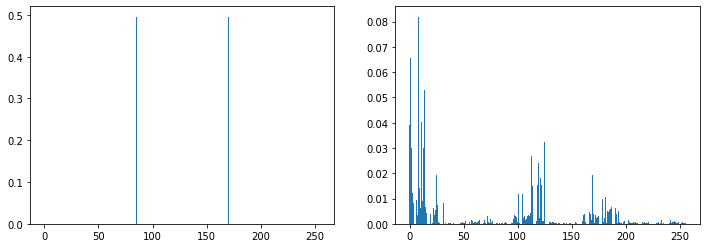

In [399]:
compare_compression(*compression)

### Look at all test

In [400]:
compressions = [get_compression(delta=i) for i in range(len(train_set))]    

<ipython-input-396-7c7b561cab8b>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2, figsize=(12, 4))


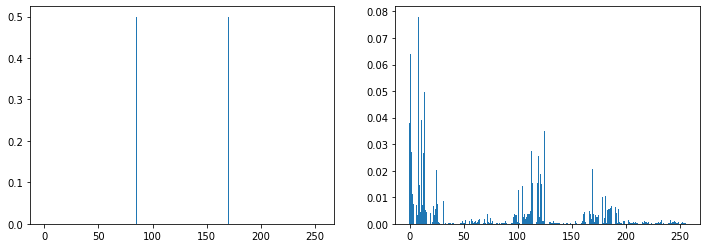

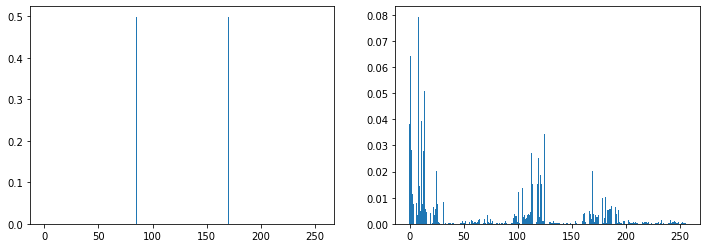

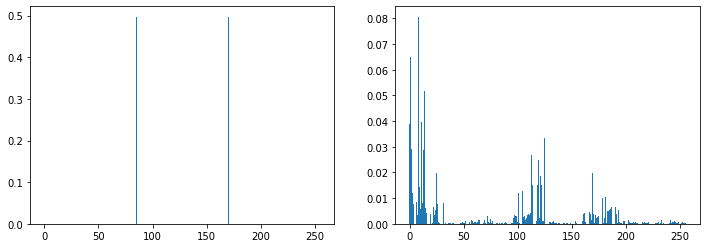

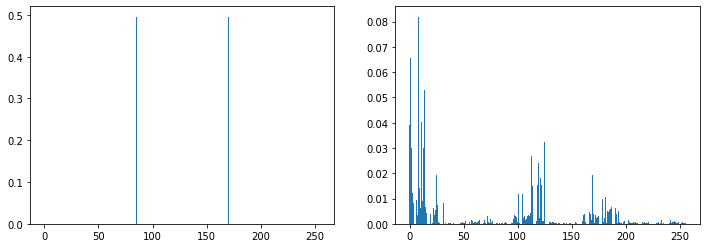

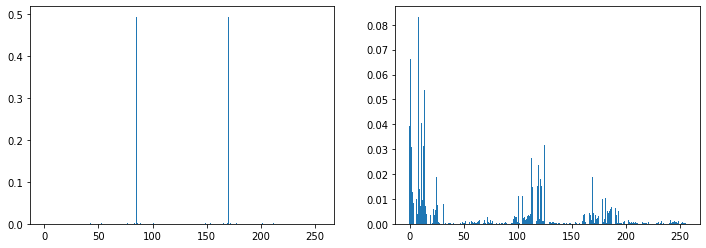

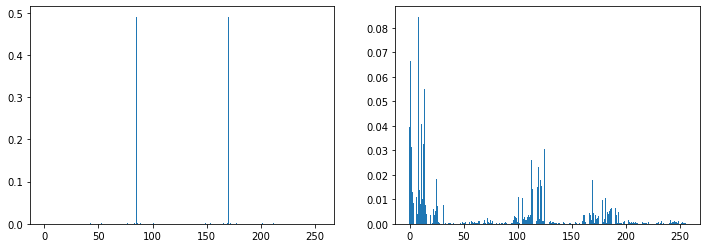

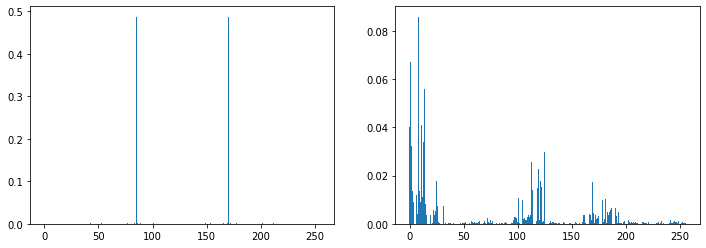

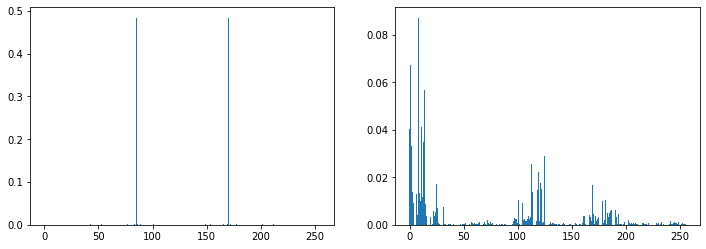

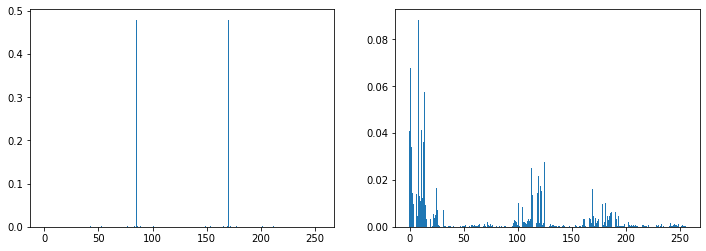

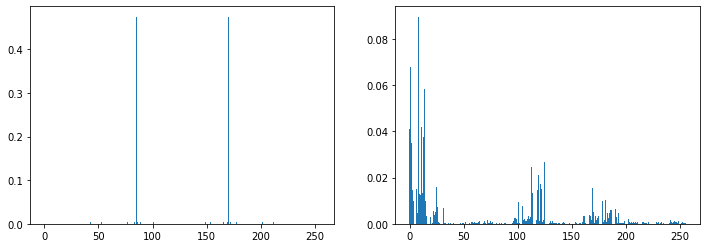

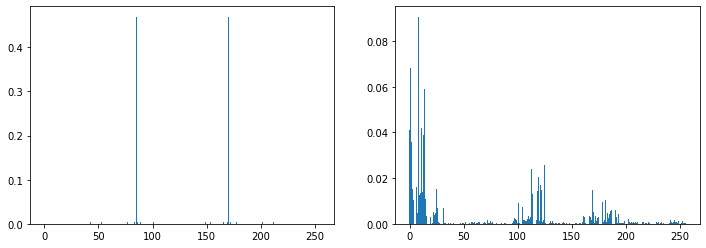

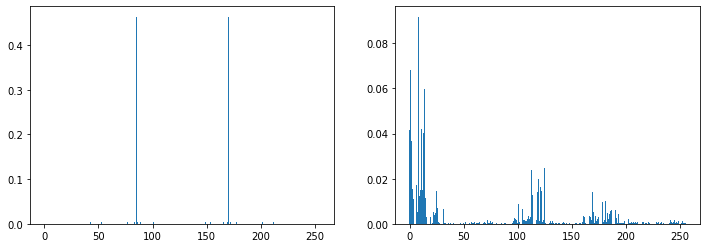

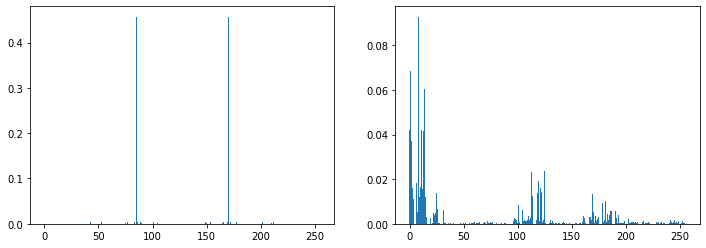

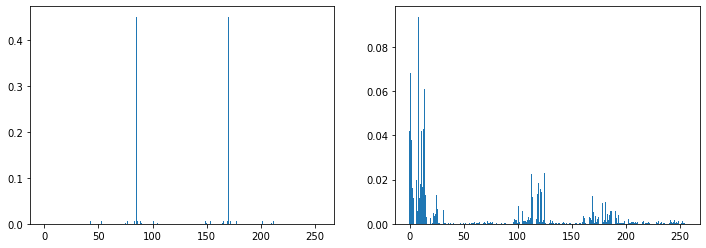

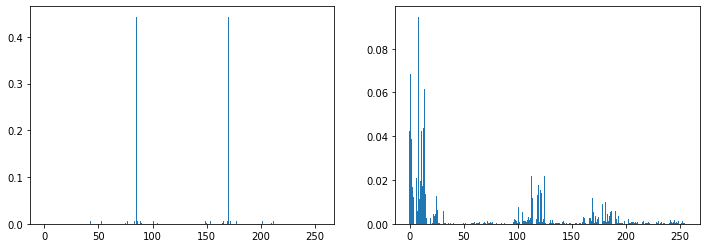

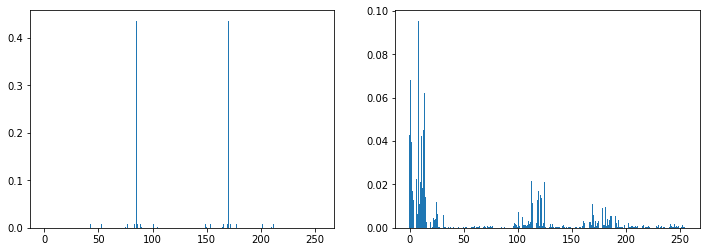

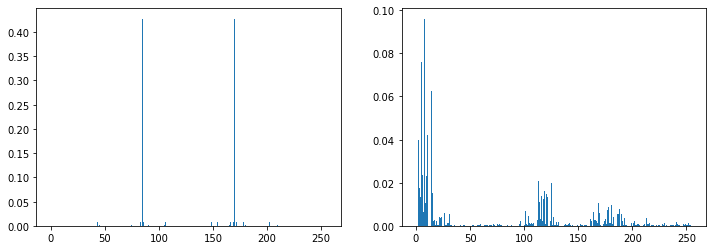

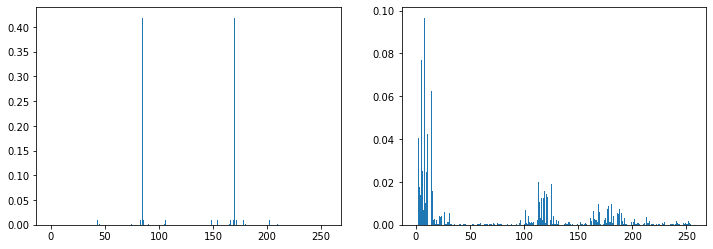

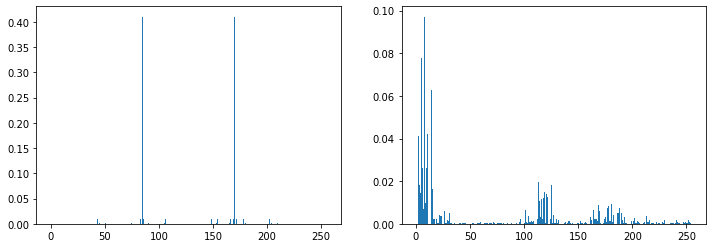

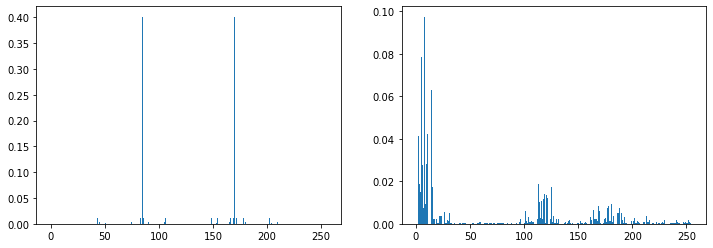

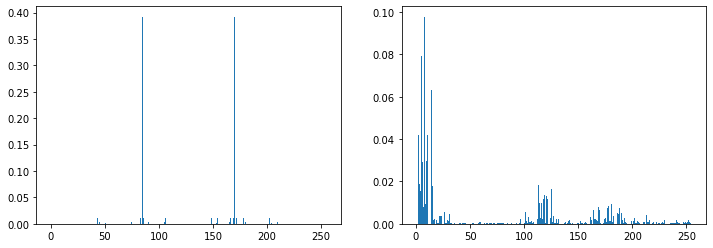

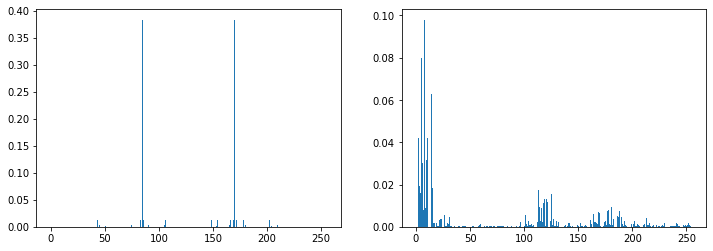

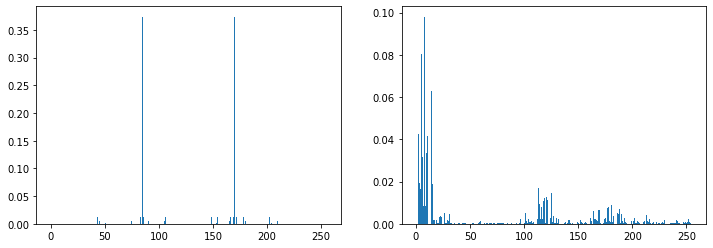

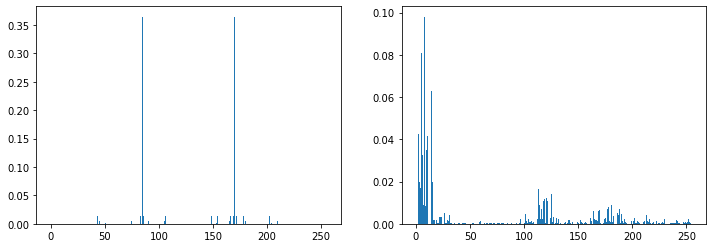

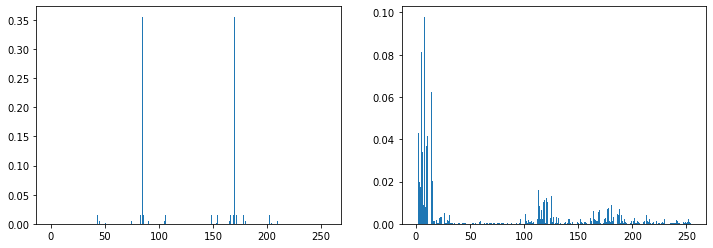

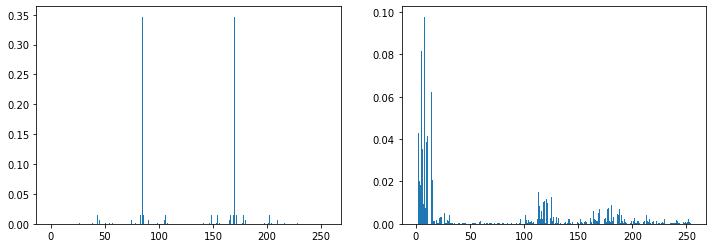

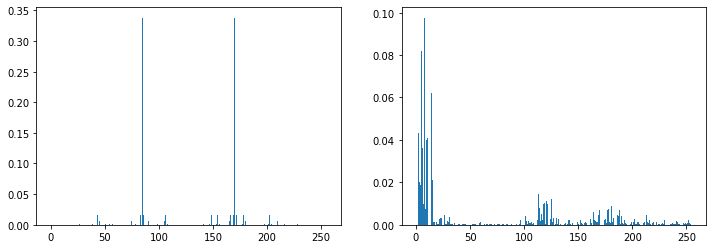

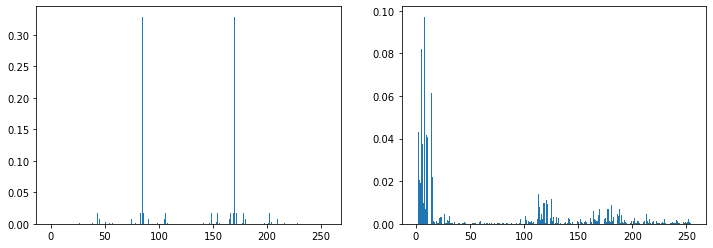

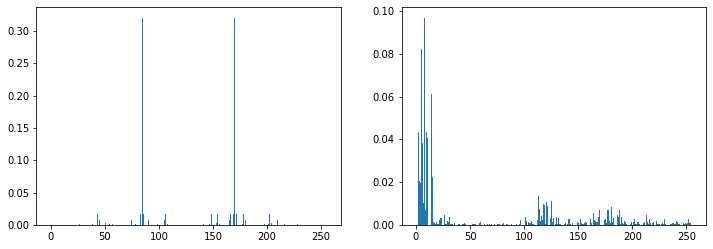

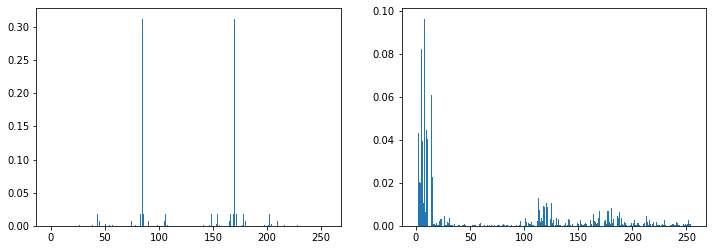

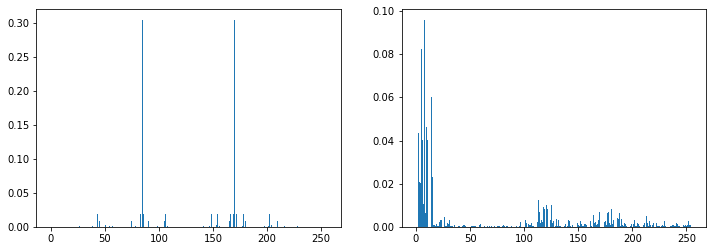

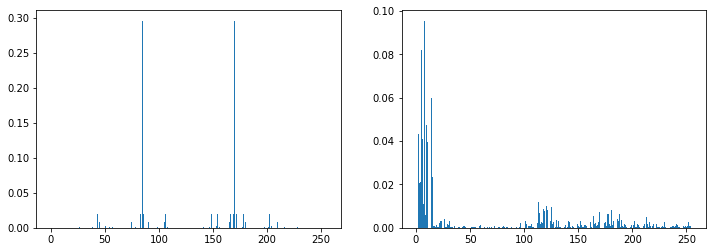

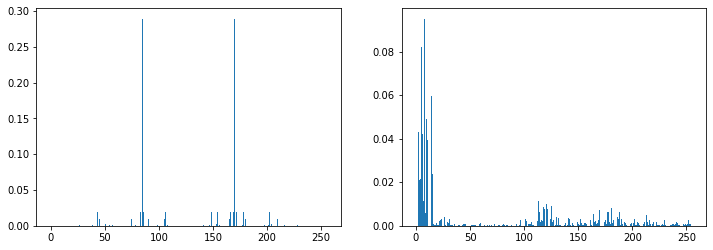

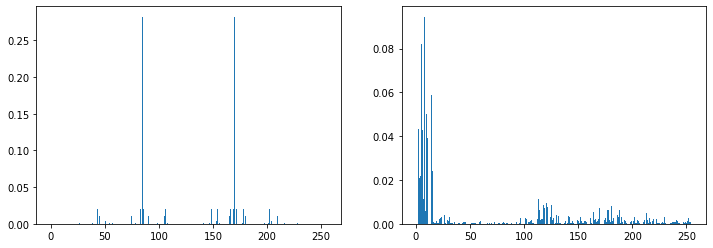

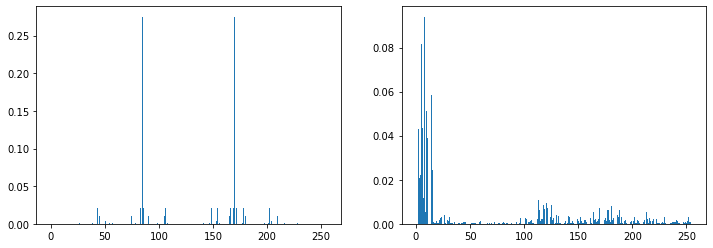

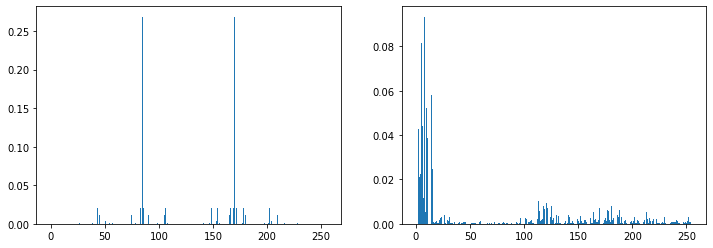

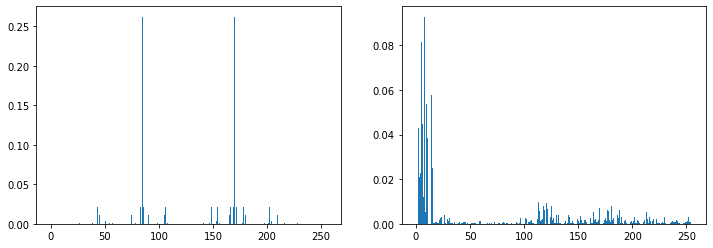

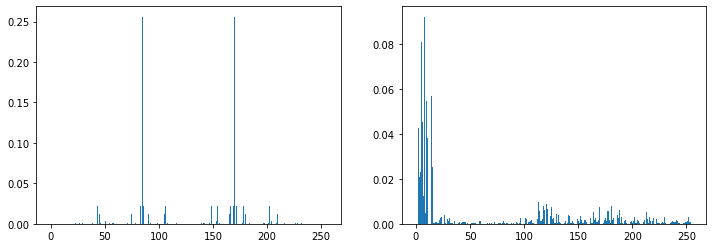

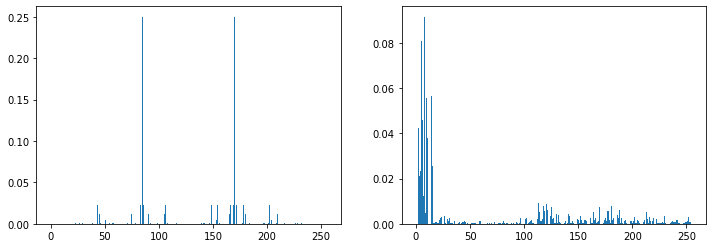

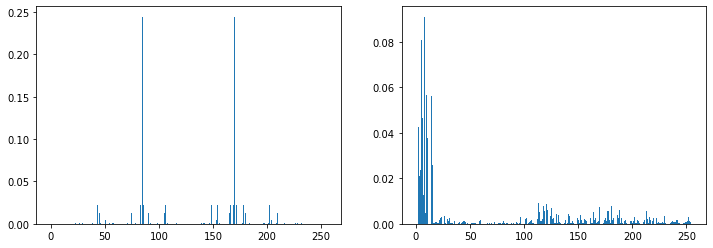

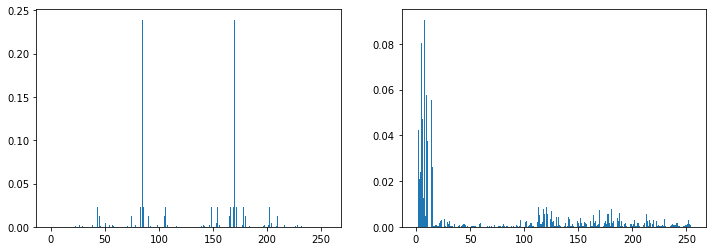

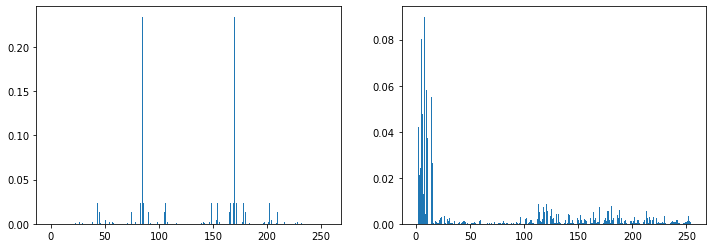

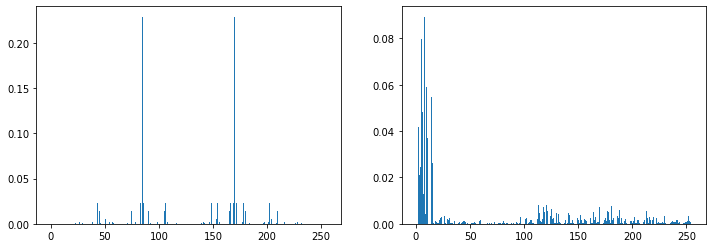

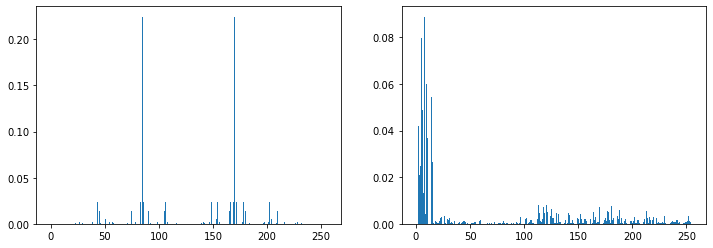

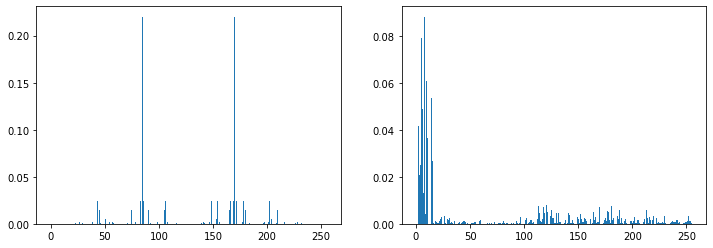

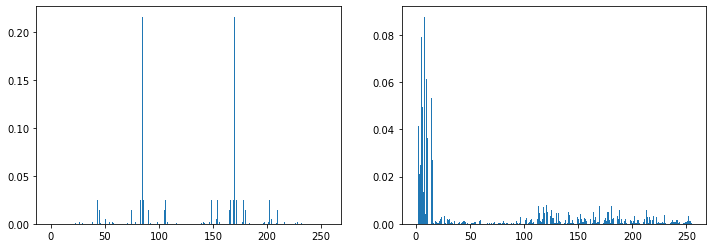

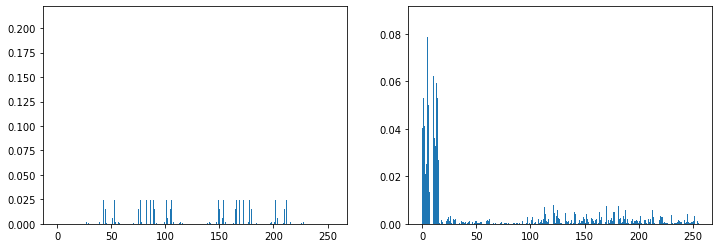

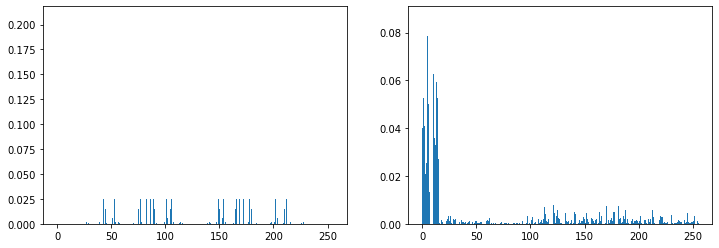

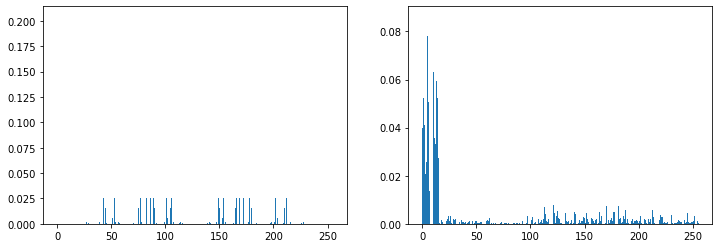

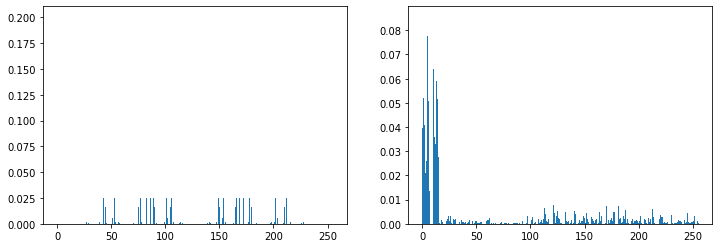

In [401]:
_ = [compare_compression(*i) for i in compressions]

In [ ]:
compressed